# Imports

In [78]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser

import torch
import torch.nn as nn

import datasets
from model import CNN

import utils
reload(utils)

<module 'utils' from '/Users/petr12375/Documents/mipt/m1p/2023-Project-120/code/utils.py'>

# Hyperparameters

In [74]:
layers = 1
batch_size = 64
log_frequency = 10
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [4]:
dataset = "fashionmnist"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

# Architecture search for a range of $\lambda$

In [79]:
save_folder = 'checkpoints/0'
epochs = 1
weight = 1e3
lambd = 1

for weight in [1e3]:
    for lambd in [1]:
        print(f"weight = {weight}, lambd = {lambd}")
        if dataset == "fashionmnist":
            model = CNN(32, 1, channels, 10, layers)
        if dataset == "cifar10":
            model = CNN(32, 3, channels, 10, layers)

        criterion = nn.CrossEntropyLoss() # mycriterion()
        optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
        trainer = utils.MyDartsTrainer( # MyDartsTrainer
            model=model,
            loss=criterion, # =mycriterion,
            metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
            optimizer=optim,
            num_epochs=epochs,
            dataset=dataset_train,
            batch_size=batch_size,
            log_frequency=log_frequency,
            unrolled=unrolled,
            weight=weight, # вес регуляризатора
            lambd=lambd, # количество общих ребер
            train_as_optimal=False,
            optimalPath='checkpoints/fashionMNIST/optimal/arc.json',
            tau=0.98,
        )
        trainer.fit()
        final_architecture = trainer.export()
        print('Final architecture:', final_architecture)
        json.dump(trainer.export(), open(f'checkpoints/fashionMNIST/lambd=0.5/arc.json', 'w+'))
        # json.dump(trainer.export(), open(f"checkpoints/lambd={lambd}" + '/arc.json', 'w+'))


weight = 1000.0, lambd = 1
{'reduce_n2_p0': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n2_p1': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n3_p0': tensor([0.0029, 0.9829, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029]), 'reduce_n3_p1': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n3_p2': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n4_p0': tensor([0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029, 0.0029]), 'reduce_n4_p1': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.9829]), 'reduce_n4_p2': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n4_p3': tensor([0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029, 0.0029]), 'reduce_n5_p0': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n5_p1': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029, 0.0029]), 'reduce_n5_p2': tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.9829, 0.0029

KeyboardInterrupt: 

In [6]:

nas_modules = trainer.get_nas_modeles()

In [14]:
for name, module in nas_modules[-5:]:
    print(name)
    print(module.alpha)

reduce_n5_p4
Parameter containing:
tensor([ 0.0001,  0.0002,  0.0007,  0.0001, -0.0008, -0.0008,  0.0027],
       requires_grad=True)
reduce_n2_switch
Parameter containing:
tensor([ 9.6014e-07, -8.6201e-04], requires_grad=True)
reduce_n3_switch
Parameter containing:
tensor([-0.0021, -0.0011, -0.0008], requires_grad=True)
reduce_n4_switch
Parameter containing:
tensor([-9.3561e-05,  3.7959e-04, -1.4919e-04,  8.9289e-04],
       requires_grad=True)
reduce_n5_switch
Parameter containing:
tensor([-1.9891e-03,  2.6625e-03, -4.7200e-04, -2.4569e-05, -4.5821e-04],
       requires_grad=True)


In [109]:
mod.alpha

Parameter containing:
tensor([-0.0008,  0.0023], requires_grad=True)

In [72]:
a = torch.zeros(3)
parents = [0, 1]
a[parents] = 1
a

tensor([1., 1., 0.])

# TMP

In [69]:
from torch.distributions import RelaxedOneHotCategorical

a = torch.tensor([2, 0.5, -0.5])
b = RelaxedOneHotCategorical(logits=a, temperature=0.5).rsample().t()
b[0]

tensor(0.6498)

In [149]:
p1 = 0.9
p2 = 0.5
n = 10
p3 = 1e-2
p1 ** n * p3 / (p1 ** n * p3 + (1 - p3) * p2 ** n)

0.7829169795979716

In [150]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [151]:
class person:
    def __init__(self):
        if random.random() <= 1e-4:
            self.is_oracle = True
        else:
            self.is_oracle = False
    def prediction(self):
        if self.is_oracle:
            if random.random() <= 0.9:
                return True
            else:
                return False
        if not self.is_oracle:
            if random.random() <= 0.5:
                return True
            else:
                return False

In [152]:
x = []
y = []

n_person = 100
n_experiment = 1000
for k in tqdm(range(1, 1000, 10)):
    total = 0
    for _ in range(n_experiment):
        all = np.random.rand(n_person)
        is_oracle = (all < 1e-4)
        correct = np.zeros(n_person)
        
        for _ in range(k):
            drop = np.random.rand(n_person)
            oracle_drop = drop * is_oracle
            human_drop = drop - oracle_drop
            correct += (oracle_drop >= 0.1) + (human_drop >= 0.5)

        chosen = np.argmax(correct)
        total += is_oracle[chosen]
    probab = total / n_experiment
    x.append(k)
    y.append(probab)
    # y.append(0.9 ** 10 * probab / (0.9 ** 10 * probab + (1 - probab) * 0.5 ** 10))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:18<00:00,  3.18s/it]


Text(0, 0.5, 'P(A)')

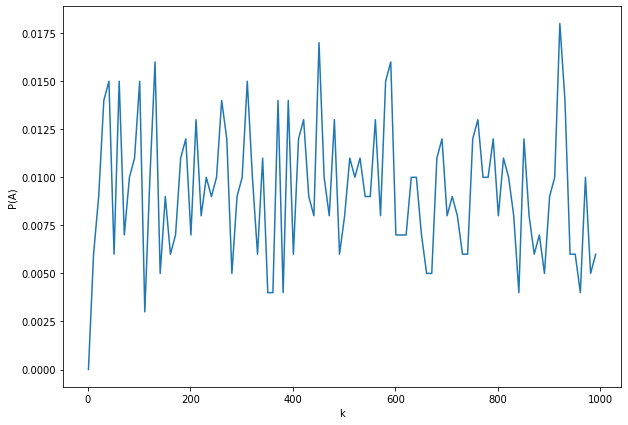

In [159]:
plt.figure(figsize=(10, 7))
plt.plot(x, y)
plt.xlabel("k")
plt.ylabel("P(A)")

In [160]:
x_100 = []
y_100 = []

n_person = 100
n_experiment = 10000
for k in tqdm(range(1, 100)):
    total = 0
    for _ in range(n_experiment):
        all = np.random.rand(n_person)
        is_oracle = (all < 1e-4)
        correct = np.zeros(n_person)
        
        for _ in range(k):
            drop = np.random.rand(n_person)
            oracle_drop = drop * is_oracle
            human_drop = drop - oracle_drop
            correct += (oracle_drop >= 0.1) + (human_drop >= 0.5)

        chosen = np.argmax(correct)
        total += is_oracle[chosen]
    probab = total / n_experiment
    x_100.append(k)
    y_100.append(probab)
    # y.append(0.9 ** 10 * probab / (0.9 ** 10 * probab + (1 - probab) * 0.5 ** 10))

100%|██████████| 99/99 [03:05<00:00,  1.87s/it]


Text(0, 0.5, 'P(A)')

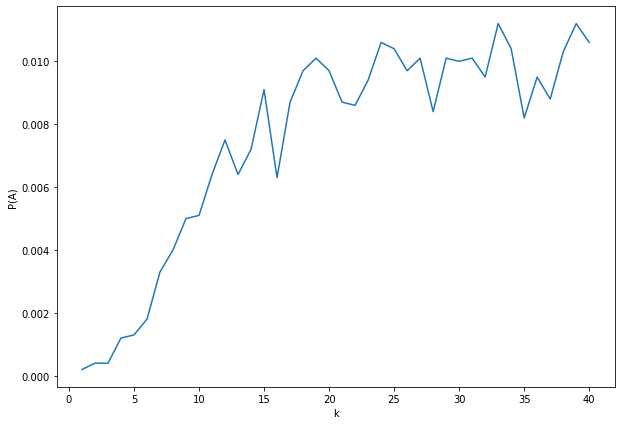

In [167]:
plt.figure(figsize=(10, 7))
plt.plot(x_100[:40], y_100[:40])
plt.xlabel("k")
plt.ylabel("P(A)")

In [217]:
n_experiments = 1000

x_plot = np.linspace(0.01, 0.99)
y_plot = []
for boarder in tqdm(x_plot):
    sum_K = 0
    for _ in range(n_experiments):
        K = 0
        rho = 0
        while rho <= boarder:
            x = np.random.normal(size=12)
            y = np.random.normal(size=12)
            x_ = np.average(x)
            y_ = np.average(y)
            sigma_x = np.var(x)
            sigma_y = np.var(y)
            rho = np.sum((x - x_) * (y - y_)) / (12 * sigma_x * sigma_y)
            K += 1
        sum_K += K
    ans = sum_K / n_experiments
    y_plot.append(ans)

100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


Text(0, 0.5, 'K')

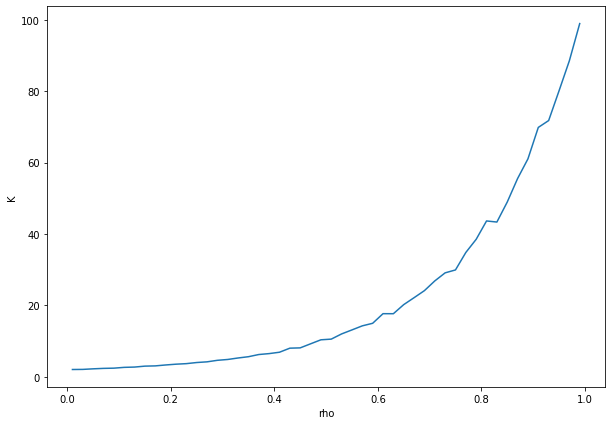

In [218]:
plt.figure(figsize=(10, 7))
plt.plot(x_plot, y_plot)
plt.xlabel("rho")
plt.ylabel("K")

In [205]:
1 / (1 - 0.9998769)

8123.47684808817

In [206]:
1 - 0.83

0.17000000000000004

In [207]:
1 / 0.170

5.88235294117647